# Primene tehnika klasifikacije na primeru ocene kvaliteta različitih vina
## Seminarski rad u okviru kursa Mašinsko učenje
## Nikola Pujaz 21m/19

## Učitavanje potrebnih biblioteka

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

## Analiza podataka i pretprocesiranje

In [4]:
# NAPOMENA: Potrebno je sačuvati dataset na željenoj lokaciji na Google Drive servisu 
#           i zameniti adresni string, kako bi dataset bio uspešno učitan.
wineData = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/datasets/winequality-red.csv")

In [5]:
# Pregled osnovnih meta podataka skupa podataka.
print("Broj instanci u skupu podataka: ", wineData.shape[0])
print("Broj atributa(kolona): ", wineData.shape[1])
print("Nazivi atributa:")
for col in wineData.columns:
  print(col)

Broj instanci u skupu podataka:  1599
Broj atributa(kolona):  12
Nazivi atributa:
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality


In [6]:
# Pregled NULL vrednosti po atributima.
print('NULL vrednosti po atributima: \n')
print(wineData.isnull().sum())

NULL vrednosti po atributima: 

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# Uklanjanje duplikata.
wineData = wineData.drop_duplicates()
print("Broj instanci nakon uklanjanj duplikata: ", wineData.shape[0])

Broj instanci nakon uklanjanj duplikata:  1359


In [8]:
# Pregled tipova atributa.
wineData.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [9]:
wineData.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5


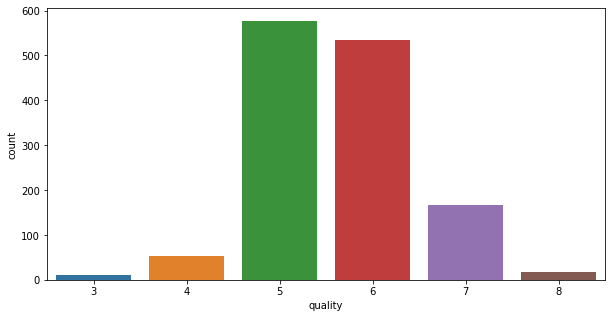

In [10]:
# Pregled instanci po pripadajućim klasama
plt.subplots(figsize=(10,5))
sns.countplot(wineData.quality);

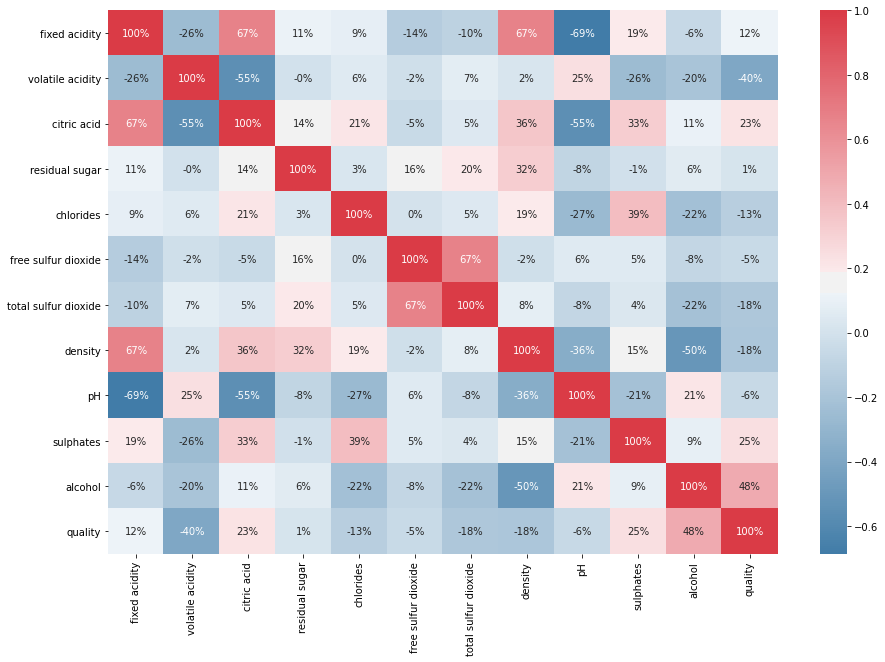

In [11]:
correlationMatrix = wineData.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(correlationMatrix, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), fmt='.0%');

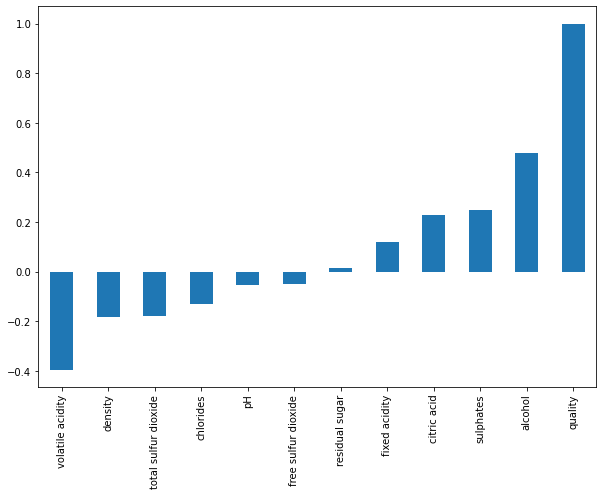

In [12]:
# Pregled međusobnih zavisnosti između atributa "quality" i ostalih atributa
qualityCorr = correlationMatrix['quality'].sort_values()
plt.subplots(figsize=(10,7))
qualityCorr.plot(kind = 'bar');

In [13]:
print(abs(qualityCorr) > 0.2)

volatile acidity         True
density                 False
total sulfur dioxide    False
chlorides               False
pH                      False
free sulfur dioxide     False
residual sugar          False
fixed acidity           False
citric acid              True
sulphates                True
alcohol                  True
quality                  True
Name: quality, dtype: bool


In [14]:
wineDataSelected = wineData[['alcohol','sulphates','citric acid','volatile acidity','quality']]
wineDataSelected.head()

,alcohol,sulphates,citric acid,volatile acidity,quality
0,9.4,0.56,0.00,0.70,5
1,9.8,0.68,0.00,0.88,5
2,9.8,0.65,0.04,0.76,5
3,9.8,0.58,0.56,0.28,6
5,9.4,0.56,0.00,0.66,5


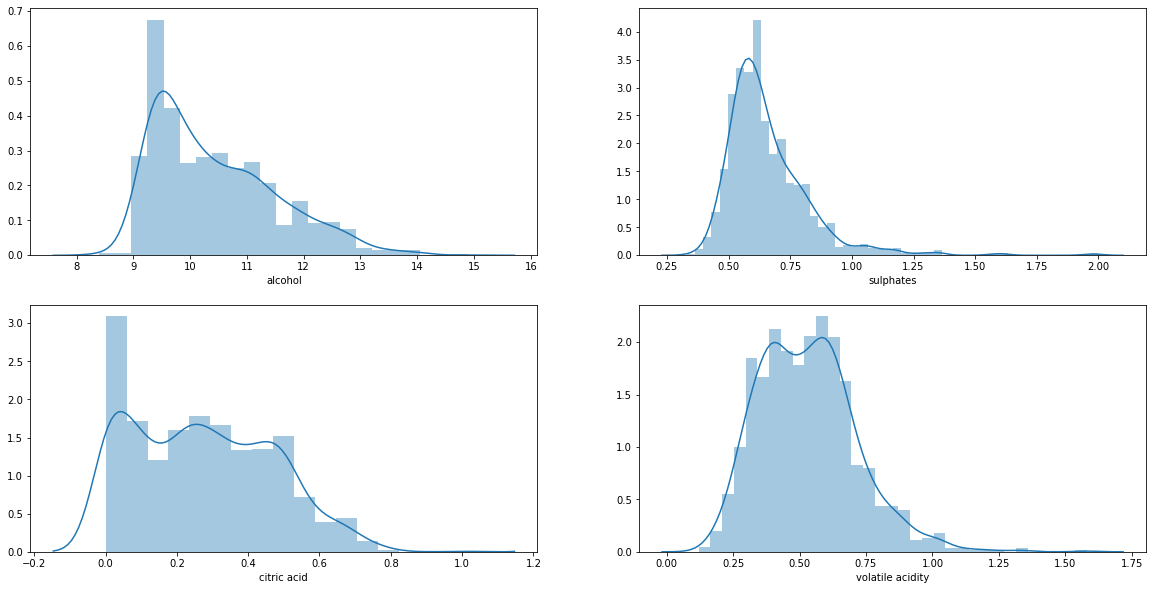

In [15]:
# Pregled distribucija vrednosti po atributima.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, col in enumerate(wineDataSelected.columns[:-1]):
  sns.distplot(wineDataSelected[col],ax=axes[i//2, i%2])    
plt.show()

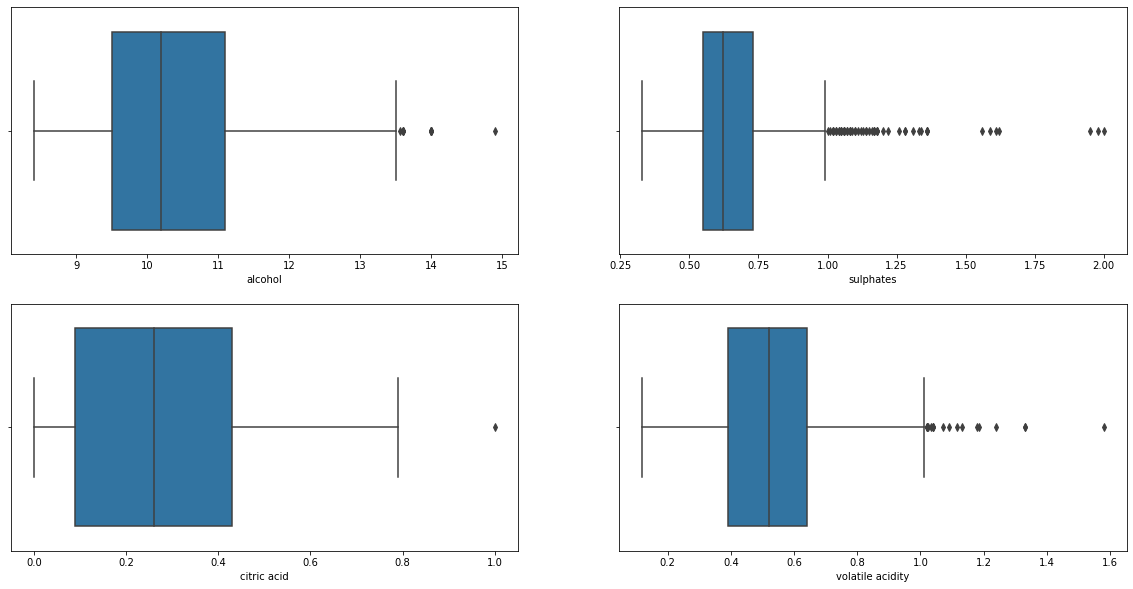

In [16]:
# Vizualizacija sa ciljem identifikacije outliera.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, col in enumerate(wineDataSelected.columns[:-1]):
  sns.boxplot(wineDataSelected[col],ax=axes[i//2, i%2])    
plt.show()

In [17]:
# Podela na trening i test skup
X = wineDataSelected.drop('quality', axis=1)
Y = wineDataSelected['quality']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 7)

In [18]:
# Skaliranje
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns = X.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = X.columns)

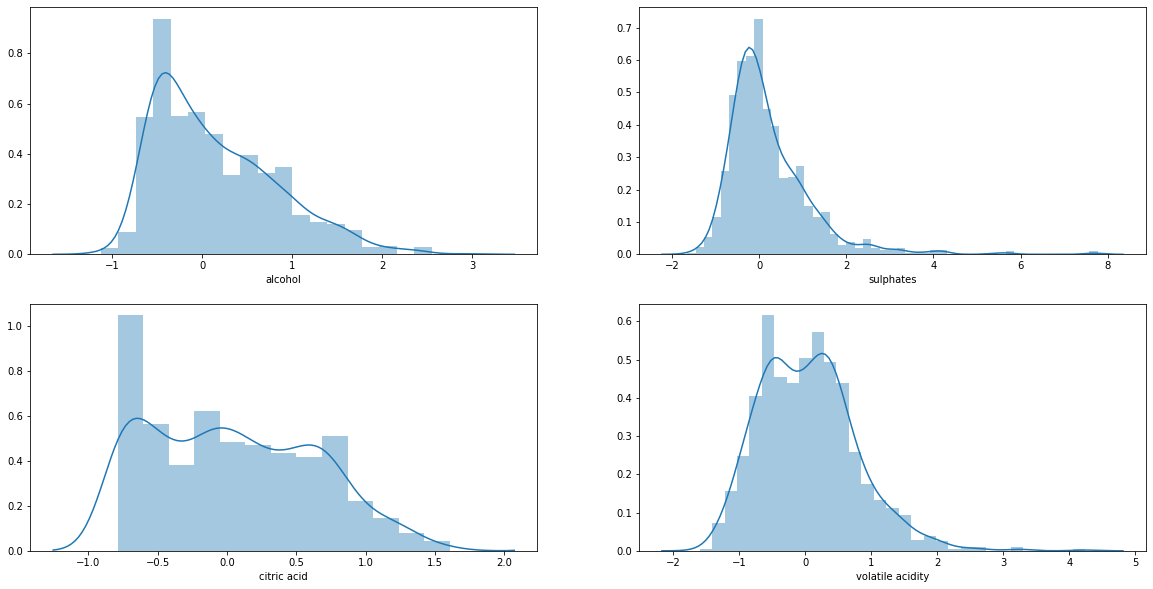

In [19]:
# Pregled distribucija vrednosti po atributima nakon skaliranja.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, col in enumerate(x_train_scaled):
  sns.distplot(x_train_scaled[col],ax=axes[i//2, i%2])
plt.show()

## Logistička Regresija

In [20]:
# Logistička regresija
logReg = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=800) \
        .fit(x_train_scaled, y_train)
logRegPrediction = logReg.predict(x_test_scaled)

61.4%


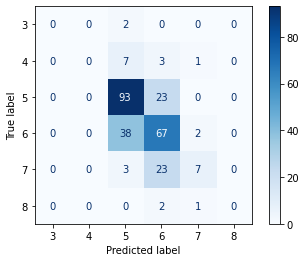

In [21]:
logRegAccuracy = accuracy_score(y_test, logRegPrediction)
print(f'{round(logRegAccuracy*100,2)}%')
disp = plot_confusion_matrix(logReg, x_test_scaled, y_test,
                             cmap=plt.cm.Blues, values_format='d')
plt.show()

## Pretvaranje numeričkog atributa u nominalni

In [22]:
# Pretvaranje numeričkog klasnog atributa u nominalni.
y_train_nominal = y_train.replace({0:"bad", 1:"bad", 2:"bad",  
                 3:"good", 4:"good", 5:"good",
                 6:"very good", 7:"very good", 8:"very good",
                 9:"excellent", 10:"excellent"})
y_test_nominal = y_test.replace({0:"bad", 1:"bad", 2:"bad",  
                 3:"good", 4:"good", 5:"good",
                 6:"very good", 7:"very good", 8:"very good",
                 9:"excellent", 10:"excellent"})

## Stablo odlučivanja

In [23]:
# Stablo Odlučivanja
decisionTree = DecisionTreeClassifier().fit(x_train_scaled,y_train_nominal)
decisionTreePrediction = decisionTree.predict(x_test_scaled)
# TODO: 10-fold CV

66.54%


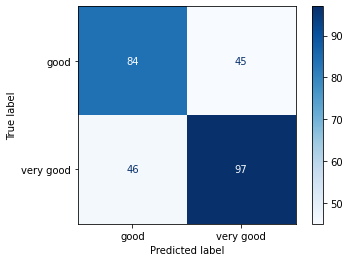

In [24]:
dtAccuracy = accuracy_score(y_test_nominal, decisionTreePrediction)
print(f'{round(dtAccuracy*100,2)}%')
disp = plot_confusion_matrix(decisionTree, x_test_scaled, y_test_nominal,
                             cmap=plt.cm.Blues, values_format='d')
plt.show()

## Naive-Bayes

In [25]:
# Enkodiranje klasnog atributa.
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(y_train_nominal)

y_train_num = labelEncoder.transform(y_train_nominal)
y_test_num = labelEncoder.transform(y_test_nominal)

y_train_encoded = pd.DataFrame(y_train_num)
y_test_encoded = pd.DataFrame(y_test_num)

In [26]:
# Naive-Bayes
naiveBayes = GaussianNB().fit(x_train_scaled,y_train_encoded.values.ravel())
naiveBayesPrediction = naiveBayes.predict(x_test_scaled)

74.63%


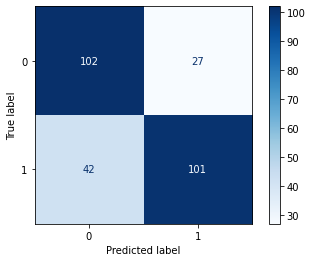

In [27]:
nbAccuracy = accuracy_score(y_test_encoded, naiveBayesPrediction)
print(f'{round(nbAccuracy*100,2)}%')
disp = plot_confusion_matrix(naiveBayes, x_test_scaled, y_test_encoded.values.ravel(),
                             cmap=plt.cm.Blues, values_format='d')
plt.show()

## PCA - Principal Components Analysis

In [28]:
# Podela na trening i test skup
X = wineData.drop('quality', axis=1)
Y = wineData['quality']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 7)

In [29]:
# Skaliranje
scaler = preprocessing.RobustScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns = X.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = X.columns)

In [30]:
pca = PCA(.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [31]:
pca.n_components_

7

### Logistička Regresija nakon PCA

In [32]:
# Logistička regresija
logReg = LogisticRegression(solver='saga' , multi_class='multinomial', max_iter=800) \
         .fit(x_train_pca, y_train)
logRegPrediction = logReg.predict(x_test_pca)

62.13%


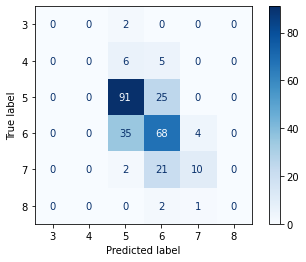

In [33]:
logRegAccuracy = accuracy_score(y_test, logRegPrediction)
print(f'{round(logRegAccuracy*100,2)}%')
disp = plot_confusion_matrix(logReg, x_test_pca, y_test,
                             cmap=plt.cm.Blues, values_format='d')
plt.show()

### Stablo odlučivanja nakon PCA

In [34]:
# Pretvaranje numeričkog klasnog atributa u nominalni.
y_train_nominal = y_train.replace({0:"bad", 1:"bad", 2:"bad",  
                 3:"good", 4:"good", 5:"good",
                 6:"very good", 7:"very good", 8:"very good",
                 9:"excellent", 10:"excellent"})
y_test_nominal = y_test.replace({0:"bad", 1:"bad", 2:"bad",  
                 3:"good", 4:"good", 5:"good",
                 6:"very good", 7:"very good", 8:"very good",
                 9:"excellent", 10:"excellent"})

In [35]:
# Stablo Odlučivanja nakon PCA
decisionTree = DecisionTreeClassifier().fit(x_train_pca,y_train_nominal)
decisionTreePrediction = decisionTree.predict(x_test_pca)
# TODO: 10-fold CV

68.38%


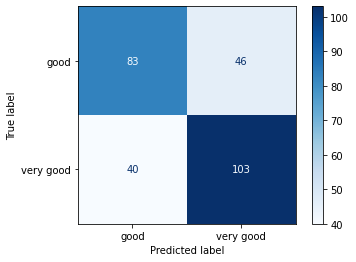

In [36]:
dtAccuracy = accuracy_score(y_test_nominal, decisionTreePrediction)
print(f'{round(dtAccuracy*100,2)}%')
disp = plot_confusion_matrix(decisionTree, x_test_pca, y_test_nominal,
                             cmap=plt.cm.Blues, values_format='d')
plt.show()

### Naive-Bayes nakon PCA

In [37]:
# Enkodiranje klasnog atributa
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(y_train_nominal)

y_train_num = labelEncoder.transform(y_train_nominal)
y_test_num = labelEncoder.transform(y_test_nominal)

y_train_encoded = pd.DataFrame(y_train_num)
y_test_encoded = pd.DataFrame(y_test_num)

In [38]:
# Naive-Bayes
naiveBayes = GaussianNB().fit(x_train_pca,y_train_encoded.values.ravel())
naiveBayesPrediction = naiveBayes.predict(x_test_pca)

75.74%


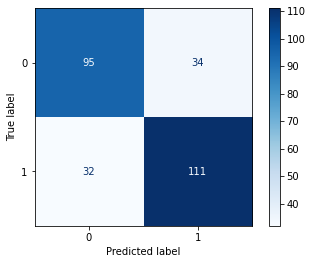

In [39]:
nbAccuracy = accuracy_score(y_test_encoded, naiveBayesPrediction)
print(f'{round(nbAccuracy*100,2)}%')
disp = plot_confusion_matrix(naiveBayes, x_test_pca, y_test_encoded.values.ravel(),
                             cmap=plt.cm.Blues, values_format='d')
plt.show()